# CSE 40 Take-Home Final: apelyush

Your unique dataset consists of physiochemical properties of a selection of Portuguese Vinho Verde wines.

Some wines are red, some are white. A boolean label for high-quality white wines has been provided.

You are free to use any library code provided within the `cse40` conda environment.

In [1]:
""" 
By Alexei Pelyushenko
06/10/2021

Hope you enjoy! This took a while, but it was a great first time getting a 
machine learning pipeline up and running.
"""

import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy import stats

from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# You may import sklearn models of your choosing. For example,
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('data.csv')

df.head()

,density,sulphates,chlorides,volatile acidity,pH,quality white
0,0.9998 g/cm^3,0.41 g(potassium sulphate)/dm^3,0.042 g(sodium chloride)/dm^3,0.22 g(acetic acid)/dm^3,3.36,True
1,0.9914 g/cm^3,0.44 g(potassium sulphate)/dm^3,0.041 g(sodium chloride)/dm^3,0.31 g(acetic acid)/dm^3,3.31,True
2,0.9952 g/cm^3,0.51 g(potassium sulphate)/dm^3,0.058 g(sodium chloride)/dm^3,0.18 g(acetic acid)/dm^3,3.13,True
3,0.99785 g/cm^3,0.61 g(potassium sulphate)/dm^3,0.097 g(sodium chloride)/dm^3,0.54 g(acetic acid)/dm^3,3.39,False
4,0.9898 g/cm^3,0.37 g(potassium sulphate)/dm^3,0.03 g(sodium chloride)/dm^3,0.22 g(acetic acid)/dm^3,3.16,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   density           999 non-null    object 
 1   sulphates         999 non-null    object 
 2   chlorides         999 non-null    object 
 3   volatile acidity  1000 non-null   object 
 4   pH                1000 non-null   float64
 5   quality white     1000 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 40.2+ KB


In [3]:
def extract_first_number(source_str):
    '''
    extract the first numerical value appearing in a string
    as a float and return it, allowing negative numbers and 
    decimal values
    '''
    
    if pd.isna(source_str) or source_str.startswith('NA'):
        return np.nan

    # find instances of a valid numerical substrings in the source string
    # see https://regex101.com/r/gwP6Qy/2 for an explanation
    matches = re.search(r'-?\d+\.?\d*', source_str.replace(',', ''))
    
    # if there are any valid numerical substrings
    if matches:
        return float(matches[0]) # convert the first one to a float and return the value
    else:
        return np.nan
    
def convert_data(df, exclude_columns=[]):
    '''
    Convert the columns of a dataframe from strings containing numbers to
    the first number appearing in each string.
    
    Args:
        df: A pandas dataframe
        exclude_columns: A list of columns that should not be converted
        
    Returns:
        A pandas dataframe
    '''
    
    for c in df.columns:
        
        if c not in exclude_columns:          
            for i in range(1000):
                data = str(df[c][i])
                new_data = extract_first_number(data)
                #df[c][i] = new_data
                #This problem didn't come up when I used it back in homework 2
                df[c].iloc[i] = new_data
        else:
            pass
        
    return df

df = convert_data(df, ['quality white'])

c:\programdata\miniconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
df = df.apply(pd.to_numeric) #thank god this doesn't switch bools
print(df.corrwith(df.get("quality white")))
# df = df.drop(columns=['sulphates'])
# drop if doing so will raise performance
# Interesting how these are all inversely correlated.
# Alex from the future: dropping sulphates reduced performance overall. Strangely it made 
#     the logistic regression have normal results.

density            -0.373739
sulphates          -0.200181
chlorides          -0.417833
volatile acidity   -0.645981
pH                 -0.304970
quality white       1.000000
dtype: float64


In [5]:
def nadata(df):
    # Input: Dataframe, Output: Amount of NaNs in table
    
    nans = df.isnull().sum(axis=1).tolist()
    nanamount = 0
    for i in range(len(df)):
        if nans[i] > 0:
            nanamount += 1
    return nanamount

print("Missing data values: {}".format(nadata(df)))
print("\nNo need to worry about dropping rows too much.")

Missing data values: 3

No need to worry about dropping rows too much.


In [6]:
df = df.dropna()
print(nadata(df))
#This^ should be zero.
#I'm kind of glad this dataset has very few nans

0


Outlier


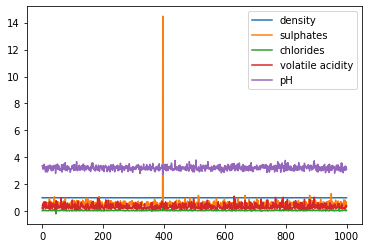

In [7]:
df.plot()
print("Outlier")

Rows to drop: [93, 394, 44, 185, 394, 593, 663, 946]


<AxesSubplot:>

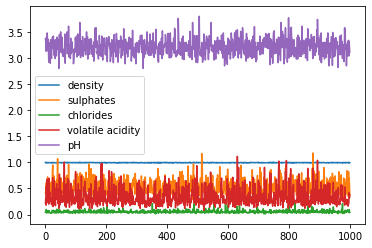

In [8]:
drop = []
# Code that will search for and store information on which rows contain outliers.
for c in df.columns:
    scores = stats.zscore(df[c])
    for i in range(len(scores)):
        if abs(scores[i]) > 5:
            drop.append(i)
print("Rows to drop: {}".format(drop))
df = df.drop(df.index[drop])
df.plot()

<AxesSubplot:xlabel='volatile acidity', ylabel='sulphates'>

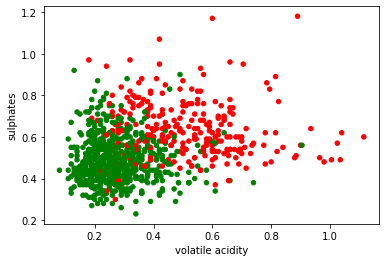

In [9]:
color = []
for i in range(len(df['quality white'])):
    if df['quality white'].iloc[i]:
        color.append('green')
    else:
        color.append('red')
df.plot.scatter(x ='volatile acidity', 
                y = 'sulphates',
                c = color)
                
#Can't exactly plot anything against quality, so I guess I'll try acidity and sulphates.
#My guess is that the graph should look somewhat random.
#After having seen it, I predicted incorrectly, but this makes more sense. Since everything is negatively correlated,
#if the quality is good, then the values should be lower.

<AxesSubplot:xlabel='density', ylabel='pH'>

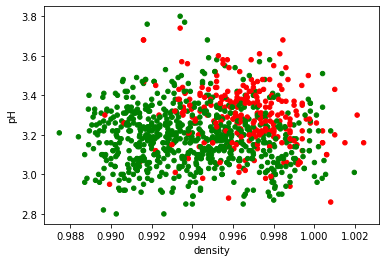

In [10]:
df.plot.scatter(x = 'density',
                y = 'pH',
                c = color)
#I chose these two features since they share a similar correlation to the target variable.
#I find it interesting that the resulting graph is relatively centered.

In [11]:
linear_model = SGDClassifier(
    loss='log'
)
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5
)
knn_model = KNeighborsClassifier(
    n_neighbors=8
)

models = {
    'linear': linear_model,
    'tree': tree_model, 
    'KNN': knn_model
}

k = 5 #Changing this changes the f1 scoring drastically
kf = KFold(k)

In [12]:
tree2_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5
)

X = df.drop(columns = ['quality white'])
y = df['quality white']
tree2_model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [13]:
#Test
fee = [[1,1,1,1,1],[-1,-1,-1,-1,-1],[0,0,0,0,0]]
out = tree2_model.predict(fee)
print(out)

[False False False]


In [14]:
def kfold_validate(models, kf, X, y):

    #y = y.to_numpy().ravel() 
    
    scores = {}
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    for name, model in models.items():
        scores[name] = cross_val_score(model, X, y, scoring = "f1", cv = kf)
    
    return scores

In [15]:
scores = kfold_validate(models, kf, X, y)
print(scores)
#They all seem pretty decent. The decision tree was the best by a 
#considerable margin.

{'linear': array([0.86746988, 0.94805195, 0.95      , 0.94076655, 0.92976589]), 'tree': array([0.96376812, 0.96393443, 0.96463023, 0.93950178, 0.93617021]), 'KNN': array([0.94661922, 0.94389439, 0.94533762, 0.93950178, 0.92465753])}


In [16]:
#T statistic comparison with the models.
def tpair_statistic(model1_scores, model2_scores):
    '''
    return probability of null hypothesis 
    (that points were sampled from same distribution)
    '''

    deltai = []
    n = len(model1_scores)

    for i in range(n):
        deltai.append(model1_scores[i] - model2_scores[i])

    avgdelta = sum(deltai)/n
    
    diffs = []
    for i in range(n):
        diffs.append(pow(deltai[i] - avgdelta, 2))
    s = pow(sum(diffs)/n, 0.5)
    
    t = avgdelta/(s/pow(n-1, 0.5))
    
    # compute the pvalue from a two-tailed t-statistic `t`
    pval = stats.t.sf(np.abs(t), len(model1_scores)-1) * 2
    
    return pval

def report(a, b):
    pval = tpair_statistic(scores[a], scores[b])
    print(f'T-Pair score for {a} and {b}:', pval)

In [17]:
report('linear', 'tree')
report('linear', 'KNN')
report('tree', 'KNN')
#The linear and KNN models are strangely close at K = 5. Higher than that and the probabilities go down.
#It seems that the higher the n_fold parameter in KFold, the lower the probabilities that 2 f1 scores
#could be equal.

T-Pair score for linear and tree: 0.2112436902468924
T-Pair score for linear and KNN: 0.4840332568180819
T-Pair score for tree and KNN: 0.021540991751119346


In [18]:
#Testing for the accuracies of each model

def model_accuracy(model, df, tests = 10):
    
    train_acc = []
    test_acc = []
    
    for i in range(tests):
        #Split data randomly
        train_data = df.sample(frac = 0.5)
        test_data = df.drop(train_data.index)
        
        train_true = train_data['quality white']
        test_true = test_data['quality white']
        train_data = train_data.drop(columns = ['quality white'])
        test_data = test_data.drop(columns = ['quality white'])
        
        #Find the accuracy of the model on the training data
        model.fit(train_data, train_true)
        train_pred = model.predict(train_data)
        train_acc.append(accuracy_score(train_true, train_pred))
        
        #Find the accuracy of the model on the training data
        test_pred = model.predict(test_data)
        test_acc.append(accuracy_score(test_true, test_pred))
        
    return [(sum(train_acc)/tests, np.std(train_acc)), (sum(test_acc)/tests, np.std(test_acc))]

In [19]:
data_L = model_accuracy(linear_model, df)
data_T = model_accuracy(tree_model, df)
data_K = model_accuracy(knn_model, df)

#Woo, everything works

print(f'All results for the linear model: {data_L}')
print(f'Test results for the linear model: {data_L[1]}')

All results for the linear model: [(0.8678787878787878, 0.0397235626864823), (0.8769696969696967, 0.044005639137390286)]
Test results for the linear model: (0.8769696969696967, 0.044005639137390286)


In [20]:
d = {
    'Test Accuracy': [data_L[1][0], data_T[1][0], data_K[1][0]],
    'Test Standard deviation of accuracy': [data_L[1][1], data_T[1][1], data_K[1][1]],
    'Train - Test Accuracy': [data_L[0][0] - data_L[1][0], 
                              data_T[0][0] - data_T[1][0],
                              data_K[0][0] - data_K[1][0]]
}
results = pd.DataFrame(d)
results.index = ['Logistic Regression', 'Decision Tree', 'K-nearest Neighbors']
results.head()

,Test Accuracy,Test Standard deviation of accuracy,Train - Test Accuracy
Logistic Regression,0.876970,0.044006,-0.009091
Decision Tree,0.924040,0.016639,0.047677
K-nearest Neighbors,0.906667,0.012447,0.021010
